In [34]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import tensorflow as tf
from pickle import dump
%matplotlib inline

In [2]:
with open('BTC_hist_daily_prices.json') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data['Data']['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
df = df.drop(['conversionType', 'conversionSymbol'], axis=1 )
target_col = 'close'

df.head(100)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2010-07-17,0.04951,0.04951,0.04951,20.00,0.9902,0.04951
2010-07-18,0.08585,0.05941,0.04951,75.01,5.0920,0.08584
2010-07-19,0.09307,0.07723,0.08584,574.00,49.6600,0.08080
2010-07-20,0.08181,0.07426,0.08080,262.00,20.5900,0.07474
2010-07-21,0.07921,0.06634,0.07474,575.00,42.2600,0.07921
...,...,...,...,...,...,...
2010-10-20,0.10300,0.09400,0.09700,31855.00,3221.0800,0.09900
2010-10-21,0.10900,0.09700,0.09900,44867.00,4616.8500,0.10700
2010-10-22,0.10900,0.10150,0.10700,34603.91,3665.4300,0.10250


In [3]:
# Splits and shuffles the dataset into train, validation and test sets.

def train_val_test_split(df, validation_size=0.1, test_size=0.05):
    return np.split(df, [int((1-validation_size)*len(df)), int((1-test_size)*len(df))]) 

train_df, validation_df, test_df = train_val_test_split(df)

In [4]:
print('train:', train_df.shape)
print('validation:', validation_df.shape)
print('test:', test_df.shape)

train: (3411, 6)
validation: (190, 6)
test: (190, 6)


In [5]:
# Normalize values between 0-1 for every feature (each column is divided by column max value).

scaler = MinMaxScaler()
scaler.fit(train_df)

train_scaled = scaler.transform(train_df)
validation_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_df)

train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns,index=train_df.index)
validation_scaled_df = pd.DataFrame(validation_scaled, columns=validation_df.columns,index=validation_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns,index=test_df.index)

train_scaled_df.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2010-07-17,0.000000,0.000002,0.000000,0.000035,1.585403e-10,0.000000
2010-07-18,0.000002,0.000003,0.000000,0.000131,8.152768e-10,0.000002
2010-07-19,0.000002,0.000004,0.000002,0.001003,7.951030e-09,0.000002
2010-07-20,0.000002,0.000003,0.000002,0.000458,3.296651e-09,0.000001
2010-07-21,0.000001,0.000003,0.000001,0.001005,6.766221e-09,0.000002


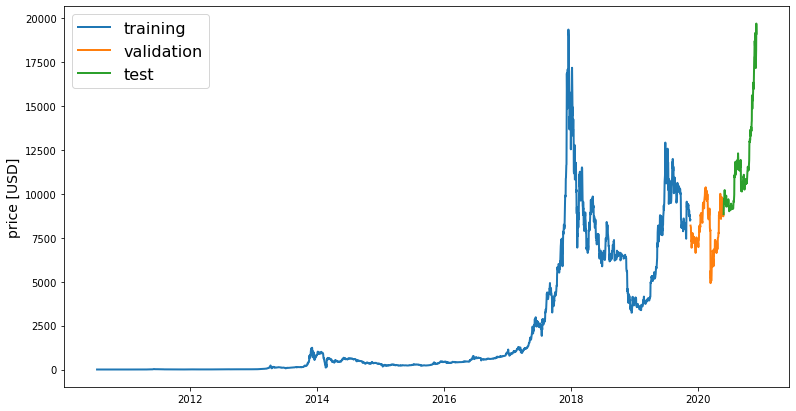

In [6]:
def line_plot(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train_df[target_col], validation_df[target_col], test_df[target_col], 'training', 'validation', 'test', title='')

In [7]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10):
#    train_data, validation_data, test_data = train_val_test_split(df)
#    X_train = extract_window_data(train_data, window_len)
#    X_val = extract_window_data(validation_data, window_len)
#    X_test = extract_window_data(test_data, window_len)
#    y_train = train_data[target_col][window_len:].values
#    y_val = validation_data[target_col][window_len:].values
#    y_test = test_data[target_col][window_len:].values

#    return X_train, X_val, X_test, y_train, y_val, y_test

    x = extract_window_data(df, window_len)
    y = df[target_col][window_len:].values
    
    return x, y

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    #model.add(LSTM(neurons, return_sequences=True, input_shape =(input_data.shape[1],input_data.shape[2])))
    #model.add(Dropout(dropout))
    #model.add(LSTM(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [21]:
np.random.seed(42)
window_len = 10
lstm_neurons = 100
epochs = 200
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [23]:
#X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_scaled, target_col, window_len=window_len)

X_train, y_train = prepare_data(train_scaled_df, target_col, window_len=window_len)
X_val, y_val = prepare_data(validation_scaled_df, target_col, window_len=window_len)
X_test, y_test = prepare_data(test_scaled_df, target_col, window_len=window_len)

In [24]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[es, mc])

Epoch 1/200
 98/107 [==========================>...] - ETA: 0s - loss: 0.0018   
Epoch 00001: val_loss improved from inf to 0.00565, saving model to best_model.h5
107/107 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0056
Epoch 2/200
105/107 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 00002: val_loss improved from 0.00565 to 0.00115, saving model to best_model.h5
107/107 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 3/200
103/107 [===========================>..] - ETA: 0s - loss: 0.0011   
Epoch 00003: val_loss improved from 0.00115 to 0.00070, saving model to best_model.h5
107/107 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 6.9842e-04
Epoch 4/200
105/107 [============================>.] - ETA: 0s - loss: 0.0017  
Epoch 00004: val_loss improved from 0.00070 to 0.00065, saving model to best_model.h5
107/107 [==============================] - 1s 7ms/step - loss: 0.0017

In [25]:
# load the best modell
model = load_model('best_model.h5')

# evaluate the model
train_acc = model.evaluate(X_train, y_train, verbose=0)
test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.000, Test: 0.001


In [44]:
X_test.shape

(180, 10, 6)

In [26]:
preds = model.predict(X_test).squeeze()

arr = np.zeros([preds.shape[0], 6])
arr[:, 5] = preds

res = scaler.inverse_transform(arr)

df_res = pd.DataFrame(res, columns=df.columns)

df_res.head()

,high,low,open,volumefrom,volumeto,close
0,0.04951,0.01,0.04951,0.0,0.0,9618.726137
1,0.04951,0.01,0.04951,0.0,0.0,9628.741197
2,0.04951,0.01,0.04951,0.0,0.0,9588.293523
3,0.04951,0.01,0.04951,0.0,0.0,9579.771699
4,0.04951,0.01,0.04951,0.0,0.0,9674.079652


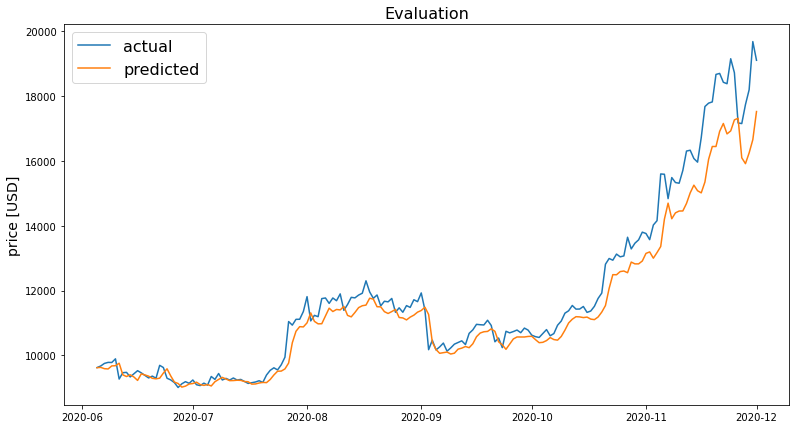

In [27]:
predicted_closing_prices = df_res[target_col].values
actual_closing_prices = test_df[target_col][window_len:]
predicted_closing_prices = pd.Series(index=actual_closing_prices.index, data=predicted_closing_prices)

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(actual_closing_prices, label='actual')
ax.plot(predicted_closing_prices, label='predicted')
ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title('Evaluation', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [28]:
res_data = {'time': test_df.index[window_len:], 'actual': test_df[target_col][window_len:], 'preds' :predicted_closing_prices}
res_df = pd.DataFrame(data=res_data)
res_df = res_df.set_index('time')

In [29]:
res_df.head()

,actual,preds
time,,
2020-06-05,9622.02,9618.726137
2020-06-06,9671.46,9628.741197
2020-06-07,9750.70,9588.293523
2020-06-08,9782.58,9579.771699
2020-06-09,9779.70,9674.079652


In [30]:
res_df.to_json(r'results.json')

In [31]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [32]:
for layer in model.layers:
    print(layer)


In [33]:
for layer in model.layers:
    print('input', layer.input_shape)
    print('output', layer.output_shape)


input (None, 10, 6)
output (None, 100)
input (None, 100)
output (None, 100)
input (None, 100)
output (None, 1)
input (None, 1)
output (None, 1)


In [41]:
# save the scaler
dump(scaler, open('scaler.pkl', 'wb'))